In [1]:
%pip install gdown
%pip install lightgbm
import pandas as pd
import lightgbm as lgb
import gdown
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,MultiLabelBinarizer,LabelEncoder

url = "https://drive.google.com/drive/folders/1gq7XBf4MKWi2JpCHdfjiPXzu8Db2p31n?usp=sharing"
gdown.download_folder(url, quiet=True)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\test.csv',
 'c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\train.csv',
 'c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\training.csv']

c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['0347', '0350', '0402', '0410', '0437', '0543', '0547', '0550', '0933', '0946', '1012', '1021', '1239', '1248', '1277', '1316', '1411', '1538', '2011', '2019'] will be ignored
  warnings.warn(
c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['0347', '0350', '0402', '0410', '0437', '0543', '0547', '0550', '0933', '0946', '1012', '1021', '1239', '1248', '1277', '1316', '1411', '1538', '2011', '2019'] will be ignored
  warnings.warn(


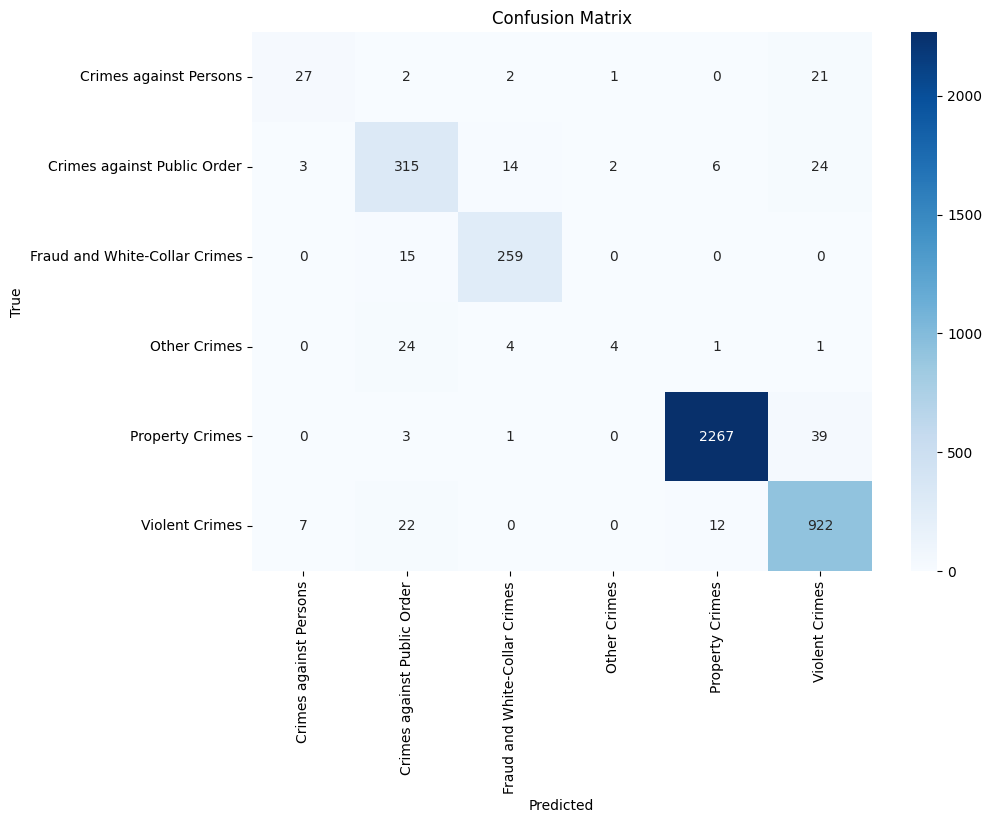

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.73      0.51      0.60        53
  Crimes against Public Order       0.83      0.87      0.85       364
Fraud and White-Collar Crimes       0.93      0.95      0.94       274
                 Other Crimes       0.57      0.12      0.20        34
              Property Crimes       0.99      0.98      0.99      2310
               Violent Crimes       0.92      0.96      0.94       963

                     accuracy                           0.95      3998
                    macro avg       0.83      0.73      0.75      3998
                 weighted avg       0.95      0.95      0.95      3998
 

Accuracy:  0.9489744872436218


In [2]:
# Step 1: Load and preprocess the dataset
train = pd.read_csv("Dataset/train.csv", sep=';')

# Remove duplicates and unnecessary columns
train = train.drop_duplicates()
train.drop('Cross_Street', axis=1, inplace=True)

# Handle missing values
train['Weapon_Used_Code'] = train['Weapon_Used_Code'].fillna(train['Weapon_Used_Code'].max() + 1)
mode_victim_sex_value = train['Victim_Sex'].mode().iloc[0]
train['Victim_Sex'] = train['Victim_Sex'].fillna(mode_victim_sex_value)
mode_victim_descent_value = train['Victim_Descent'].mode().iloc[0]
train['Victim_Descent'] = train['Victim_Descent'].fillna(mode_victim_descent_value)
mode_modus_operandi_value = train['Modus_Operandi'].mode().iloc[0]
train['Modus_Operandi'] = train['Modus_Operandi'].fillna(mode_modus_operandi_value)
train['Modus_Operandi'] = train['Modus_Operandi'].apply(lambda x: str(x).split(" ") if x else [])

# Convert dates and extract time-based features
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')
train['Year_Reported'] = train['Date_Reported'].dt.year
train['Month_Reported'] = train['Date_Reported'].dt.month
train['Day_Reported'] = train['Date_Reported'].dt.day
train['Year_Occurred'] = train['Date_Occurred'].dt.year
train['Month_Occurred'] = train['Date_Occurred'].dt.month
train['Day_Occurred'] = train['Date_Occurred'].dt.day
train['Time_Occurred'] = train['Time_Occurred'].apply(lambda x: int(x // 100))

# Encode target variable
label_encoder = LabelEncoder()
train['Crime_Category'] = label_encoder.fit_transform(train['Crime_Category'])

# Drop less relevant columns
train.drop(columns=['Year_Occurred'], inplace=True)

# Convert specific columns to integer type
columns_to_convert = ['Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code', 'Weapon_Used_Code']
train[columns_to_convert] = train[columns_to_convert].astype(int)

# Select relevant columns
included_columns = ['Location', 'Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Modus_Operandi',
                    'Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Weapon_Used_Code', 'Status',
                    'Crime_Category', 'Year_Reported', 'Month_Reported', 'Day_Reported', 'Month_Occurred', 'Day_Occurred']
new_train = train[included_columns]

# Separate features and target
X = new_train.drop('Crime_Category', axis=1)
y = new_train['Crime_Category']

# Step 2: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create custom transformer for MultiLabelBinarizer
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ml_binarizers = {}

    def fit(self, X, y=None):
        for column in X.columns:
            mlb = MultiLabelBinarizer()
            mlb.fit(X[column])
            self.ml_binarizers[column] = mlb
        return self

    def transform(self, X):
        X_transformed = []
        for column in X.columns:
            mlb = self.ml_binarizers[column]
            transformed_data = mlb.transform(X[column])
            transformed_df = pd.DataFrame(
                transformed_data, columns=[f"{column}_{cls}" for cls in mlb.classes_]
            )
            X_transformed.append(transformed_df)
        return pd.concat(X_transformed, axis=1)

# Step 4: Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), ['Area_ID', 'Reporting_District_no', 'Part 1-2', 'Victim_Sex',
                                                                      'Victim_Descent', 'Premise_Code', 'Weapon_Used_Code', 'Status',
                                                                      'Location']),
        ('minmax_scaler', MinMaxScaler(), ['Latitude', 'Longitude', 'Victim_Age']),
        ('modus_operandi', MultiLabelBinarizerTransformer(), ['Modus_Operandi'])
    ],
    remainder='passthrough'
)

# Trasforma i dati preprocessati e converti in DataFrame
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# LightGBM non accetta array non numerici. Convertiamo in DataFrame con colonne numeriche.
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)

X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train).toarray()
)
X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test).toarray()
)

# Rimuoviamo eventuali colonne non numeriche
X_train_preprocessed = X_train_preprocessed.select_dtypes(include=['int64', 'float64', 'bool'])
X_test_preprocessed = X_test_preprocessed.select_dtypes(include=['int64', 'float64', 'bool'])

# Assicuriamoci che tutti i dati siano di tipo float
X_train_preprocessed = X_train_preprocessed.astype(float)
X_test_preprocessed = X_test_preprocessed.astype(float)

# Creiamo il dataset di LightGBM
train_set = lgb.Dataset(X_train_preprocessed, label=y_train)
test_set = lgb.Dataset(X_test_preprocessed, label=y_test, reference=train_set)

# Parametri del modello
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),  # Numero di classi
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# Addestramento del modello
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
    valid_sets=[train_set, test_set]
)

# Predizioni
y_pred_proba = bst.predict(X_test_preprocessed)  # Probabilità predette
y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Predizione finale

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report, '\n')

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy: ", accuracy)